In [38]:
import numpy as np 
import cosmology as cosmo
import healpy as hp
import matplotlib.pyplot as plt
import scipy.constants as cons
from joblib import Parallel, delayed

In [39]:
cosmo_wsp = cosmo.cosmology()

In [40]:
gridsz = 128 
gridsz_in_Mpc = 7700 / 6144  # in Mpc; 7700 Mpc box length for websky 6144 cube

In [41]:
with np.load('/global/cfs/cdirs/mp107/exgal/data/xgsm/small_cube_128.npz') as cube:
    delta0 = cube['delta']
    sx = cube['sx']
    sy = cube['sy']
    sz = cube['sz']

cube.close()

In [42]:
cube_axis = np.arange(gridsz)

grid_qx, grid_qy, grid_qz = np.meshgrid(cube_axis, cube_axis, cube_axis, indexing='ij')

In [43]:
comov_q = np.sqrt((grid_qx+ 0.5)**2. + (grid_qy+0.5)**2. + (grid_qz+0.5)**2.) * gridsz_in_Mpc

grid_redshift = cosmo_wsp.comoving_distance2z(comov_q)
growthD = cosmo_wsp.growth_factor_D(grid_redshift)

In [44]:
print(np.min(comov_q[0,0]), np.max(comov_q[0,0]),np.min(comov_q[:,0,0]), np.max(comov_q[:,0,0]), np.min(comov_q[0,:,0]), np.max(comov_q[0,:,0]))

1.0853508478418257 159.79249640675835 1.0853508478418257 159.79249640675835 1.0853508478418257 159.79249640675835


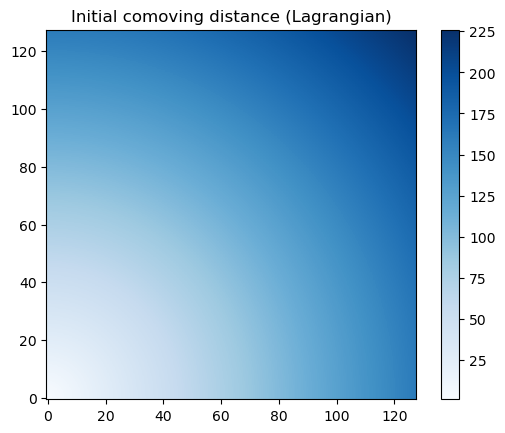

In [45]:
plt.imshow(comov_q[0,:,:], cmap=plt.cm.Blues, origin='lower')
plt.title('Initial comoving distance (Lagrangian)')
plt.colorbar()

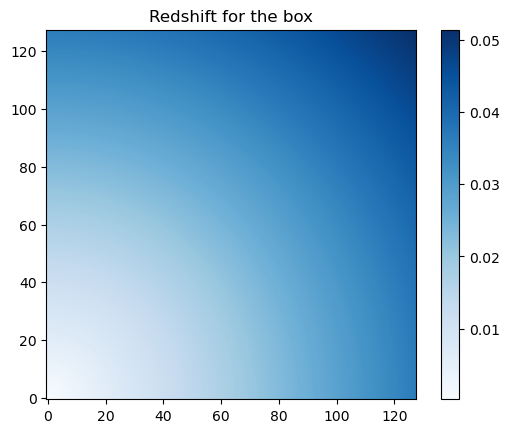

In [46]:
plt.imshow(grid_redshift[0,:,:], cmap=plt.cm.Blues, origin='lower')
plt.title('Redshift for the box')
plt.colorbar()

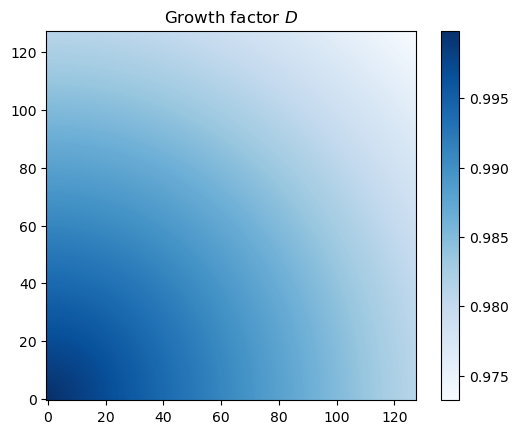

In [47]:
plt.imshow(growthD[0,:,:], cmap=plt.cm.Blues, origin='lower')
plt.title(r'Growth factor $D$ ')
plt.colorbar()

In [48]:
delta_z = growthD * delta0

grid_Xx = grid_qx + (growthD * sx)
grid_Xy = grid_qy + (growthD * sy)
grid_Xz = grid_qz + (growthD * sz)

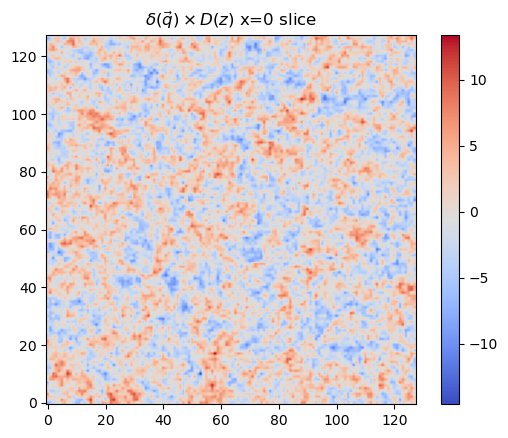

In [49]:
plt.imshow(delta_z[0,:,:], cmap=plt.cm.coolwarm, origin='lower')
plt.title(r'$\delta(\vec q) \times D(z)$ x=0 slice')
plt.colorbar()

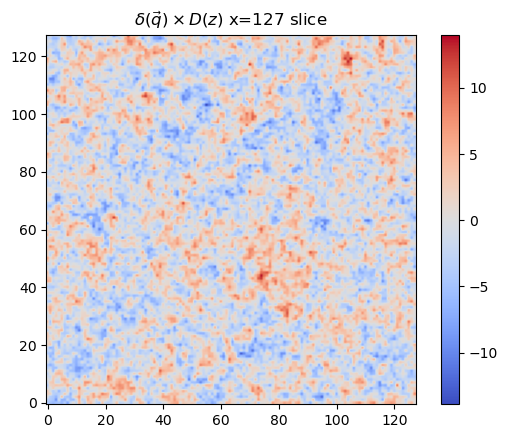

In [50]:
plt.imshow(delta_z[-1,:,:], cmap=plt.cm.coolwarm, origin='lower')
plt.title(r'$\delta(\vec q) \times D(z)$ x=127 slice')
plt.colorbar()

In [51]:
comov_X = np.sqrt((grid_Xx+ 0.5)**2. + (grid_Xy+0.5)**2. + (grid_Xz+0.5)**2.) * gridsz_in_Mpc

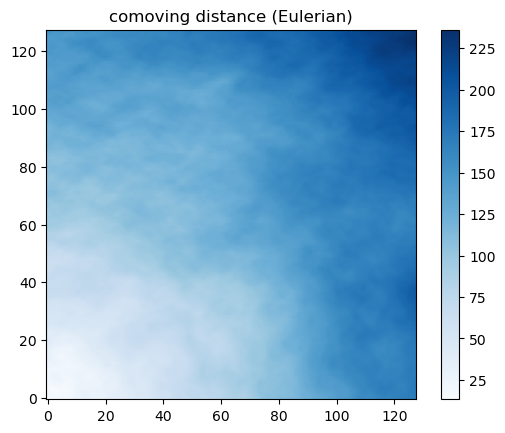

In [52]:
plt.imshow(comov_X[0,:,:], cmap=plt.cm.Blues, origin='lower')
plt.title('comoving distance (Eulerian)')
plt.colorbar()

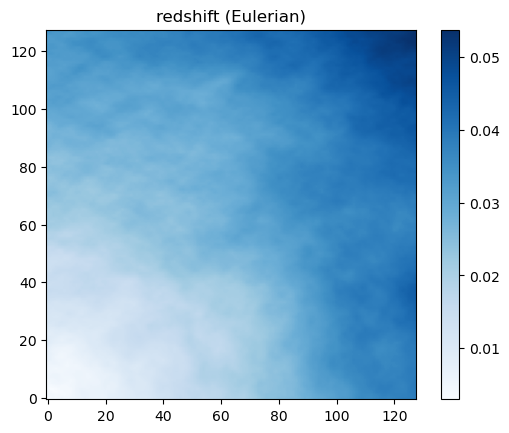

In [53]:
eulerian_redshift = cosmo_wsp.comoving_distance2z(comov_X)
plt.imshow(eulerian_redshift[0,:,:], cmap=plt.cm.Blues, origin='lower')
plt.title('redshift (Eulerian)')
plt.colorbar()

In [54]:
nside = 128
norm = np.sqrt(grid_Xx**2. + grid_Xy**2. + grid_Xz**2.)
pix = hp.vec2pix(nside, (grid_Xx/norm).flatten(), (grid_Xy/norm).flatten(), (grid_Xz/norm).flatten())
pix_grid = pix.reshape((gridsz, gridsz, gridsz))

del pix

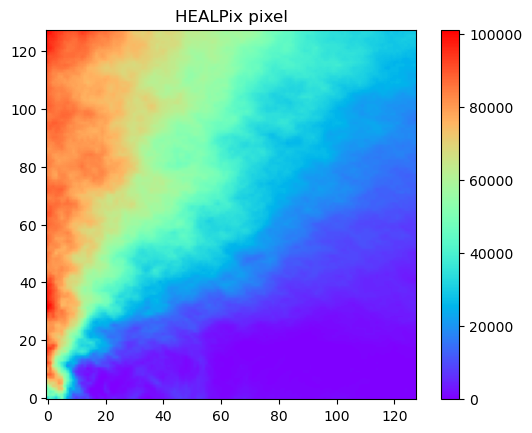

In [55]:
plt.imshow(pix_grid[0,:,:], cmap=plt.cm.rainbow, origin='lower')
plt.title('HEALPix pixel')
plt.colorbar()

In [56]:
pix_valid, npix_valid = np.unique(pix_grid, return_counts=True)

### Lensing kernel for the field term:

#### $W_\kappa(\chi_q) = \frac{3}{2} \frac{\Omega_{M,0}\ H^2_0(1+z)}{c^2} \frac{\left(1 - \chi_q\ /\chi_{q,*}\ \right)}{\chi_q}$

### Field term for each lattice point:

#### $\delta F_{ij} = \left(\frac{L_{\rm box}}{6144}\right)^3\frac{1}{\Omega_{\rm pix}} W_\kappa(z_i, \vec q_i)$

Questions: 
Is it $c^2$ or $c$ factor in the denominator? (it is $c^2$) 
For the $W_\kappa(z_i, \vec q_i)$ term do we need to multiply a $d\chi/dz$ factor? (no, it is already included)

In [57]:
X_s = 13.8 * 1.e3 # comoving distance to last scattering in Mpc
geometric_factor = gridsz_in_Mpc**3. / hp.nside2pixarea(nside)
lensing_kernel_grid = geometric_factor * (3./2.) * cosmo_wsp.params['Omega_m'] * (cosmo_wsp.params['h'] * 100.)**2. * (1 + grid_redshift) * comov_q * (1. - (comov_q/X_s)) / cons.c**2. 

In [58]:
cosmo_wsp.params['h']

0.6732

In [59]:
cons.physical_constants['speed of light in vacuum']

(299792458.0, 'm s^-1', 0.0)

In [ ]:
z = np.arange(1e-3, 1e2)
chi = cosmo_wsp.comoving_distance(z)
H_z = cosmo_wsp.Hubble_H(z)
W_kappa = (3./2.) * cosmo_wsp.params['Omega_m'] * (cosmo_wsp.params['h'] * 100.)**2. * (1 + z) / chi * (1. - (chi/X_s)) / (cons.c/1e3)**2. #/ H_z

plt.plot(z,W_kappa)
plt.xlabel(r'$z$')
plt.ylabel(r'$W_\kappa(z)$')
plt.gca().set_xlim((0,5))

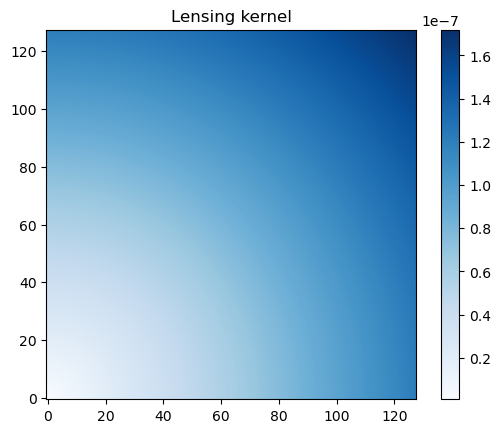

In [61]:
plt.imshow(lensing_kernel_grid[0,:,:], cmap=plt.cm.Blues, origin='lower')
plt.title('Lensing kernel')
plt.colorbar()

In [62]:
mask_comov = comov_q <= np.max(comov_q[:,0,0])
print(np.sum(mask_comov))

1085261


In [63]:
def LoS_integration4hpx(field, kernel, los_variable, comov_mask):
    return np.sum(kernel[comov_mask])#, x=los_variable[comov_mask])

def call_LoSinteg(ipix):
    sel = np.where(pix_grid.flatten() == ipix)[0]
    return LoS_integration4hpx(delta_z.flatten()[sel], lensing_kernel_grid.flatten()[sel], comov_q.flatten()[sel], mask_comov.flatten()[sel])
    

In [64]:
kappa_values = Parallel(n_jobs=-2, prefer="threads")(delayed (call_LoSinteg)(pix) for pix in pix_valid)

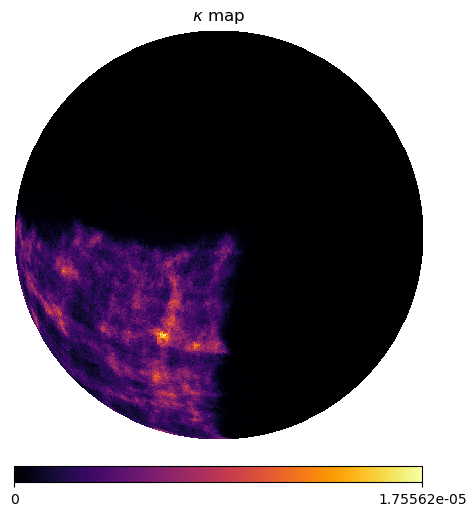

In [69]:
kappa = np.zeros(hp.nside2npix(nside))
kappa[pix_valid] = kappa_values
hp.orthview(kappa,rot=[0.,90.,0.], cmap='inferno', half_sky=True, title=r'$\kappa$ map')
#hp.graticule(dpar=10,dmer=10,ls='-', lw=0.25, c='w')